<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/improve_functionality/Field_Control_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Magic
# %matplotlib inline

# Utility Libraries
from datetime import datetime
import pytz
from google.colab import files
from scipy.ndimage import gaussian_filter

# HTML
from IPython.display import HTML

# Computation Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import multivariate_normal, gamma
from scipy.spatial.distance import pdist, squareform

# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle, Arrow

from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gamma


# Graph Libraries
import networkx as nx

from __future__ import annotations

from typing import Any, Dict, List, Optional, Sequence, Tuple, Union
import math



I Import a single play to test this out. Here we have play_id 2617 and gameId 2022092504 from the 2025 Big Data Bowl Competition.

In [35]:
df = pd.read_csv('/content/drive/MyDrive/BDB_Data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [36]:
#df = pd.read_parquet('/content/drive/MyDrive/BDB_Data/motion_df_for_pitch_control.parquet')


# Filter the DataFrame
filtered_df = df[(df['gameId'] == 2022092504) & (df['playId'] == 2617)]

# Display the filtered DataFrame
print(filtered_df.head())


   Unnamed: 0      gameId  playId    nflId   displayName  frameId  \
0           1  2022092504    2617  38632.0  Kirk Cousins        1   
1           2  2022092504    2617  38632.0  Kirk Cousins        2   
2           3  2022092504    2617  38632.0  Kirk Cousins        3   
3           4  2022092504    2617  38632.0  Kirk Cousins        4   
4           5  2022092504    2617  38632.0  Kirk Cousins        5   

     frameType                   time  jerseyNumber team  ... is_off  \
0  BEFORE_SNAP  2022-09-25 19:03:06.2           8.0  MIN  ...    1.0   
1  BEFORE_SNAP  2022-09-25 19:03:06.3           8.0  MIN  ...    1.0   
2  BEFORE_SNAP  2022-09-25 19:03:06.4           8.0  MIN  ...    1.0   
3  BEFORE_SNAP  2022-09-25 19:03:06.5           8.0  MIN  ...    1.0   
4  BEFORE_SNAP  2022-09-25 19:03:06.6           8.0  MIN  ...    1.0   

   position  pff_defensiveCoverageAssignment  \
0        QB                              NaN   
1        QB                              NaN   
2       

In [37]:
### Selecting a single player ID to test this out
one_player = [40488.0]

In [79]:
single_player = filtered_df[filtered_df['nflId'].isin(one_player)]

In [38]:

# Function to compute distance from the football for a given frame
def compute_distances_by_frame(frame_data):
    # Isolate the football's position within the frame
    football_row = frame_data[frame_data['displayName'] == 'football']
    if football_row.empty:
        # If no football is present in the frame, return NaN for distances
        frame_data['dist_from_football'] = np.nan
    else:
        football_x = football_row['x'].values[0]
        football_y = football_row['y'].values[0]
        # Compute the distance for all players in the frame
        frame_data['dist_from_football'] = np.sqrt((frame_data['x'] - football_x) ** 2 +
                                                   (frame_data['y'] - football_y) ** 2)
    return frame_data

# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-525440378.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


In [81]:
single_player[['frameId','dir','s','o']]

,frameId,dir,s,o
180,1,21.41,0.55,71.17
181,2,18.70,0.92,68.65
182,3,17.54,1.31,66.92
183,4,16.72,1.67,67.89
184,5,16.06,1.92,66.38
...,...,...,...,...
355,176,76.64,4.65,53.16
356,177,75.23,4.37,53.16
357,178,70.16,4.00,52.15
358,179,61.73,3.70,48.25


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Iterable, Optional, Tuple, Sequence

def plot_dir_orientation_small_multiples(
    df: pd.DataFrame,
    *,
    frame_ids: Optional[Sequence[int]] = None,
    base_frame: Optional[int] = None,
    offsets: Sequence[int] = (0, 29, 59, 89, 119, 149, 179),
    # columns
    frame_col: str = "frameId",
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",   # 0° = north/up, clockwise increasing
    ori_col: str = "o",     # same convention as dir (per your data)
    speed_col: str = "s",   # yards/s (optional, only for arrow scaling)
    # field + styling
    field_x_max: float = 120.0,
    field_y_max: float = 53.3,
    cols: int = 4,
    arrow_len: float = 6.0,         # base arrow length (yards)
    scale_with_speed: bool = True,  # modestly scale arrow by speed
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    grid_alpha: float = 0.15,
    title_prefix: str = "Dir vs Orientation",
    show: bool = True,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Small-multiples diagnostic for a *single player's* direction vs orientation.

    Panels show: player's (x, y) and two arrows:
      - dir_col (direction): colored `dir_color`
      - ori_col (orientation): colored `ori_color`

    Angle convention (matches your tracking):
      - 0° = due north (up, +Y)
      - degrees increase clockwise to 360°
      - conversion to matplotlib radians: theta = radians(90 - deg)

    Args
    ----
    df : DataFrame with at least [frame_col, x_col, y_col, dir_col, ori_col].
          Should be a single player's rows (or pre-filtered to one player).
    frame_ids : explicit list of frame IDs to plot (takes precedence if provided).
    base_frame : if provided (and frame_ids is None), build frames as base_frame + offsets.
    offsets : relative offsets from base_frame when frame_ids is None.
    frame_col, x_col, y_col, dir_col, ori_col, speed_col : column names.
    field_x_max, field_y_max : field dimensions in yards.
    cols : number of columns in the subplot grid.
    arrow_len : base arrow length in yards.
    scale_with_speed : if True, multiply arrow length by (0.75 + min(s, 11.3)/22.6).
    dir_color, ori_color : colors for the two arrows.
    grid_alpha : grid transparency.
    title_prefix : figure title prefix.
    show : call plt.show() before returning.

    Returns
    -------
    (fig, axes) : Matplotlib figure and flat array of Axes.
    """
    if frame_ids is None:
        if base_frame is None:
            base_frame = int(df[frame_col].min())
        frame_ids = [base_frame + off for off in offsets]

    frames_available = set(df[frame_col].unique())
    frames_to_plot = [f for f in frame_ids if f in frames_available]
    missing = [f for f in frame_ids if f not in frames_available]
    if not frames_to_plot:
        raise ValueError("None of the requested frames are present in the DataFrame.")
    if missing:
        print(f"Note: skipping missing frames: {missing}")

    def to_theta(deg: float) -> float:
        # Your convention -> matplotlib (0 rad = +X, CCW)
        return np.deg2rad(90.0 - deg)

    n = len(frames_to_plot)
    rows = int(np.ceil(n / cols))
    aspect = field_y_max / field_x_max
    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows * aspect))
    axes = np.array(axes).reshape(-1)

    for ax, fid in zip(axes, frames_to_plot):
        row = df.loc[df[frame_col] == fid]
        if row.empty:
            ax.axis("off")
            continue
        r = row.iloc[0]

        x0, y0 = float(r[x_col]), float(r[y_col])
        dir_deg = float(r[dir_col]) if pd.notna(r[dir_col]) else None
        ori_deg = float(r[ori_col]) if pd.notna(r[ori_col]) else None
        spd = float(r[speed_col]) if speed_col in r and pd.notna(r[speed_col]) else 0.0

        # modest speed scaling (keeps arrows readable)
        scale = (0.75 + min(max(spd, 0.0), 11.3) / 22.6) if scale_with_speed else 1.0
        L = arrow_len * scale

        # field + yard lines
        ax.set_xlim(0, field_x_max)
        ax.set_ylim(0, field_y_max)
        for x in range(10, int(field_x_max), 10):
            ax.axvline(x, color="k", lw=1, alpha=0.06)
        ax.scatter(x0, y0, s=60, c="k", zorder=5)

        # draw direction arrow
        if dir_deg is not None:
            th = to_theta(dir_deg)
            ax.arrow(x0, y0, L * np.cos(th), L * np.sin(th),
                     head_width=1.2, head_length=2.0, fc=dir_color, ec=dir_color, lw=1.5, zorder=6)

        # draw orientation arrow
        if ori_deg is not None:
            th_o = to_theta(ori_deg)
            ax.arrow(x0, y0, L * np.cos(th_o), L * np.sin(th_o),
                     head_width=1.2, head_length=2.0, fc=ori_color, ec=ori_color, lw=1.5, alpha=0.8, zorder=6)

        # panel title with exact values
        t_dir = f"{dir_deg:.2f}°" if dir_deg is not None else "NA"
        t_ori = f"{ori_deg:.2f}°" if ori_deg is not None else "NA"
        ax.set_title(f"Frame {fid}  |  dir={t_dir}  |  o={t_ori}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(alpha=grid_alpha)

    # turn off any extra axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.suptitle(f"{title_prefix}: direction vs orientation (player small multiples)", fontsize=14)
    fig.tight_layout(rect=[0, 0.02, 1, 0.95])

    if show:
        plt.show()
    return fig, axes


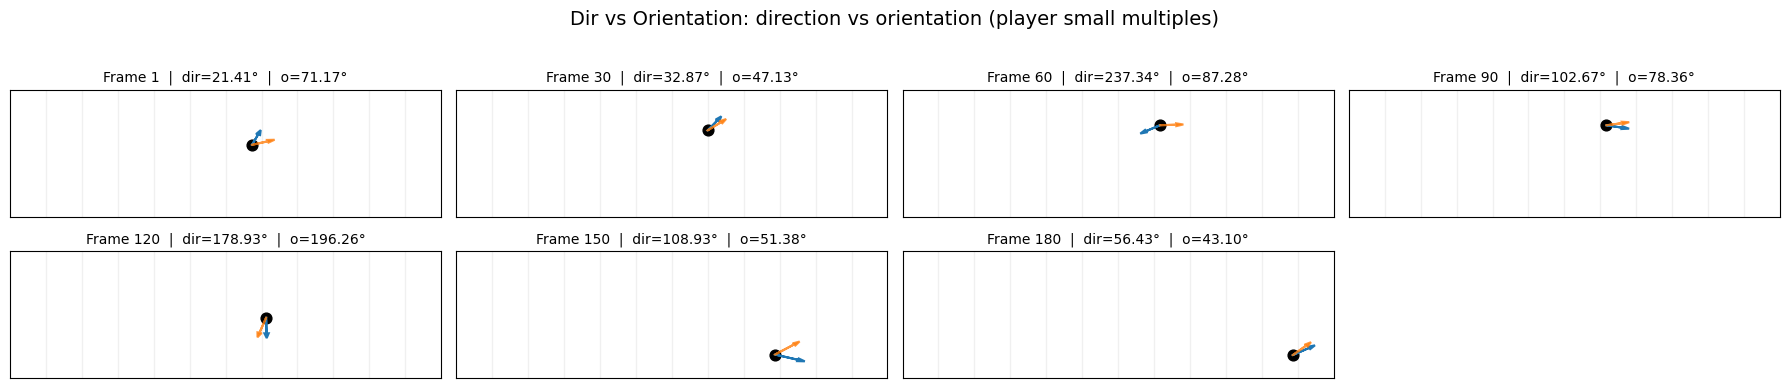

(<Figure size 1800x399.75 with 8 Axes>,
 array([<Axes: title={'center': 'Frame 1  |  dir=21.41°  |  o=71.17°'}>,
        <Axes: title={'center': 'Frame 30  |  dir=32.87°  |  o=47.13°'}>,
        <Axes: title={'center': 'Frame 60  |  dir=237.34°  |  o=87.28°'}>,
        <Axes: title={'center': 'Frame 90  |  dir=102.67°  |  o=78.36°'}>,
        <Axes: title={'center': 'Frame 120  |  dir=178.93°  |  o=196.26°'}>,
        <Axes: title={'center': 'Frame 150  |  dir=108.93°  |  o=51.38°'}>,
        <Axes: title={'center': 'Frame 180  |  dir=56.43°  |  o=43.10°'}>,
        <Axes: >], dtype=object))

In [95]:
plot_dir_orientation_small_multiples(single_player)

In [94]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, gamma


@dataclass(frozen=True)
class Grid:
    """Immutable container for the field grid."""
    X: np.ndarray  # shape (ny, nx)
    Y: np.ndarray  # shape (ny, nx)

    @property
    def x_vals(self) -> np.ndarray:
        return self.X[0, :]

    @property
    def y_vals(self) -> np.ndarray:
        return self.Y[:, 0]


class PlayerInfluenceModel:
    """
    Player influence density model (Gaussian + Gamma mix) with tunable controls.

    Angle convention (tracking data):
      - 0° = due north (+Y)
      - degrees increase clockwise to 360°
    Mapping to math/Matplotlib:
      - 0 rad = +X, CCW positive
      - theta = radians(90 - deg)     ← single, canonical conversion
    """

    def __init__(
        self,
        grid_x_res: int = 200,
        grid_y_res: int = 100,
        field_x_max: float = 120.0,
        field_y_max: float = 53.3,
        *,
        # Keep as a knob but OFF by default; only used if apply_bias=True is requested
        orientation_bias_deg: float = 0.0,
        # Gaussian controls
        gaussian_scale_factor: float = 0.7,
        # Gamma controls
        alpha_gamma: float = 11.0,
        beta_min: float = 1.0,
        beta_max: float = 20.0,
        gamma_midpoint: float = 15.0,
        gamma_scale_factor: float = 0.8,
        max_forward_distance: float = 20.0,
        forward_decay_factor: float = 1.0,
        # Angular cone
        angle_limit_min: float = 15.0,
        angle_limit_max: float = 45.0,
        angle_decay_factor: float = 2.0,
        # Mixture weights
        w_gaussian_min: float = 0.2,
        w_gaussian_max: float = 1.0,
        gaussian_midpoint: float = 4.0,
        gaussian_steepness: float = 2.0,
    ) -> None:
        # --- grid / field ---
        self.grid_x_res = int(grid_x_res)
        self.grid_y_res = int(grid_y_res)
        self.field_x_max = float(field_x_max)
        self.field_y_max = float(field_y_max)

        x_vals = np.linspace(0.0, self.field_x_max, self.grid_x_res)
        y_vals = np.linspace(0.0, self.field_y_max, self.grid_y_res)
        X, Y = np.meshgrid(x_vals, y_vals)
        self.grid = Grid(X=X, Y=Y)

        # Tunables
        self.orientation_bias_deg = float(orientation_bias_deg)
        self.gaussian_scale_factor = float(gaussian_scale_factor)

        self.alpha_gamma = float(alpha_gamma)
        self.beta_min = float(beta_min)
        self.beta_max = float(beta_max)
        self.gamma_midpoint = float(gamma_midpoint)
        self.gamma_scale_factor = float(gamma_scale_factor)
        self.max_forward_distance = float(max_forward_distance)
        self.forward_decay_factor = float(forward_decay_factor)

        self.angle_limit_min = float(angle_limit_min)
        self.angle_limit_max = float(angle_limit_max)
        self.angle_decay_factor = float(angle_decay_factor)

        self.w_gaussian_min = float(w_gaussian_min)
        self.w_gaussian_max = float(w_gaussian_max)
        self.gaussian_midpoint = float(gaussian_midpoint)
        self.gaussian_steepness = float(gaussian_steepness)

    # ------------------ Angle helpers (single source of truth) ------------------ #
    @staticmethod
    def _norm_deg(deg: float) -> float:
        """Normalize degrees to [0, 360)."""
        return (deg % 360.0 + 360.0) % 360.0

    def theta_from_tracking(self, deg: float, *, apply_bias: bool = False) -> float:
        """
        Convert tracking angle (0°=north, clockwise) → radians (0 rad = +X, CCW).

        theta = radians(90 - deg [+ orientation_bias_deg if apply_bias])
        """
        eff_deg = 90.0 - deg + (self.orientation_bias_deg if apply_bias else 0.0)
        return np.deg2rad(self._norm_deg(eff_deg))

    # ------------------ Mixture weights ------------------ #
    def dynamic_weights(self, speed: float) -> Tuple[float, float]:
        """Return (wG, wH) where wH = 1 - wG; wG decreases with speed."""
        wG = self.w_gaussian_min + (self.w_gaussian_max - self.w_gaussian_min) / (
            1.0 + np.exp(self.gaussian_steepness * (speed - self.gaussian_midpoint))
        )
        return float(wG), float(1.0 - wG)

    # ------------------ Gaussian component ------------------ #
    @staticmethod
    def _radius_influence(dist_from_ball: float) -> float:
        """Baseline radius as a function of ball distance; capped after ~18 yds."""
        if dist_from_ball <= 18.0:
            return 1.0 + (3.0 / (18.0 ** 2)) * (dist_from_ball ** 2)
        return 3.0

    def _sigma(
        self,
        theta: float,
        speed: float,
        dist_from_ball: float,
        *,
        max_speed: float = 11.3,
    ) -> np.ndarray:
        """Rotated 2×2 covariance; elongates along θ with speed; shrinks cross‑θ."""
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        ratio = float((speed ** 2) / (max_speed ** 2))
        base = self._radius_influence(dist_from_ball)
        sx = (base + base * ratio) * self.gaussian_scale_factor   # along-θ
        sy = max((base - base * ratio) * self.gaussian_scale_factor, sx * 0.5)  # cross-θ
        S = np.array([[sx, 0.0], [0.0, sy]])
        cov = R @ (S ** 2) @ R.T
        cov += np.eye(2) * 1e-6
        return cov

    @staticmethod
    def _mu(pos_xy: Tuple[float, float], vel_xy: np.ndarray) -> np.ndarray:
        """Gaussian mean at position nudged by 0.5 * velocity."""
        return np.array(pos_xy, dtype=float) + 0.5 * vel_xy

    # ------------------ Gamma anchor point ------------------ #
    def compute_offset(self, pos_xy: Tuple[float, float], direction_deg: float, speed: float) -> Tuple[float, float]:
        """
        Put gamma's reference point slightly *behind* the player so its mode falls near the player.
        """
        beta = self.beta_min + (self.beta_max - self.beta_min) / (1.0 + np.exp(1.0 * (speed - 1.0)))
        mode = (8.0 - 1.0) / beta
        th = self.theta_from_tracking(direction_deg, apply_bias=False)
        return (pos_xy[0] - mode * np.cos(th), pos_xy[1] - mode * np.sin(th))

    # ------------------ Core density ------------------ #
    def base_distribution(
        self,
        pos_xy: Tuple[float, float],
        pos_off_xy: Tuple[float, float],
        direction_deg: float,
        speed: float,
        *,
        dist_from_ball: float,
        alpha_gamma: Optional[float] = None,
    ) -> np.ndarray:
        """
        Mixed influence Z = wG * Gaussian + wH * Gamma, both normalized to [0,1] before mixing.
        """
        X, Y = self.grid.X, self.grid.Y
        x_off, y_off = pos_off_xy
        th = self.theta_from_tracking(direction_deg, apply_bias=False)

        vel = np.array([np.cos(th) * speed, np.sin(th) * speed], dtype=float)

        # Cone width narrows with speed
        ang_lim_deg = self.angle_limit_min + (self.angle_limit_max - self.angle_limit_min) * np.exp(
            -speed / self.angle_decay_factor
        )

        # Gaussian
        cov = self._sigma(th, speed, dist_from_ball)
        mu = self._mu(pos_xy, vel)
        G = multivariate_normal(mean=mu, cov=cov).pdf(np.dstack((X, Y)))
        G /= G.max() if G.max() > 0 else 1.0

        # Gamma (forward projection)
        beta_dyn = self.beta_min + (self.beta_max - self.beta_min) * (speed / self.gamma_midpoint)
        beta_dyn = np.clip(beta_dyn, self.beta_min, self.beta_max)

        dx, dy = X - x_off, Y - y_off
        d_proj = dx * np.cos(th) + dy * np.sin(th)
        d_scaled = d_proj / max(speed * (1.0 + speed / 18.0), 1e-3)

        a = float(self.alpha_gamma if alpha_gamma is None else alpha_gamma)
        H = gamma.pdf(d_scaled, a=a, scale=1.0 / (beta_dyn * self.gamma_scale_factor))

        # Fade after forward cap
        mask_far = d_proj > self.max_forward_distance
        if np.any(mask_far):
            fade = self.forward_decay_factor if self.forward_decay_factor > 0 else 1.0
            H[mask_far] *= np.exp(-((d_proj[mask_far] - self.max_forward_distance) ** 2) / (2.0 * (speed * fade) ** 2 + 1e-6))

        # Angular soft gate around θ
        ang_to_pt = np.arctan2(dy, dx)
        ang_diff = np.abs((ang_to_pt - th + np.pi) % (2.0 * np.pi) - np.pi)
        H *= 1.0 / (1.0 + np.exp(10.0 * (ang_diff - np.radians(ang_lim_deg))))
        H /= H.max() if H.max() > 0 else 1.0

        # Mix
        wG, wH = self.dynamic_weights(speed)
        Z = wG * G + wH * H
        return Z

    # ------------------ Batch per frame ------------------ #
    def compute_influence(
        self,
        df: pd.DataFrame,
        frame_id: int,
        player_ids: Optional[Iterable[int]] = None,
        *,
        id_col: str = "nflId",
        name_col: str = "displayName",
        x_col: str = "x",
        y_col: str = "y",
        speed_col: str = "s",
        dir_col: str = "dir",
        dist_from_ball_col: str = "dist_from_football",
        density_out_col: str = "density_grid",
    ) -> pd.DataFrame:
        """Compute per‑player grids for one frame."""
        f = df.loc[df["frameId"] == frame_id].copy()
        if player_ids is not None:
            if isinstance(player_ids, (int, float, str)):
                player_ids = [player_ids]
            f = f[f[id_col].isin(player_ids)].copy()
        if name_col in f.columns:
            f = f[f[name_col].str.lower() != "football"].copy()

        required = {id_col, x_col, y_col, speed_col, dir_col, dist_from_ball_col}
        missing = required - set(f.columns)
        if missing:
            raise KeyError(f"Missing required columns in df: {sorted(missing)}")

        out_rows = []
        for _, r in f.iterrows():
            pos = (float(r[x_col]), float(r[y_col]))
            dir_deg = float(r[dir_col])
            spd = float(r[speed_col])
            dball = float(r[dist_from_ball_col])

            pos_off = self.compute_offset(pos, dir_deg, spd)
            Z = self.base_distribution(
                pos_xy=pos,
                pos_off_xy=pos_off,
                direction_deg=dir_deg,
                speed=spd,
                dist_from_ball=dball,
            )
            rec = r.to_dict()
            rec[density_out_col] = Z
            out_rows.append(rec)

        return pd.DataFrame(out_rows)


In [97]:
from __future__ import annotations

from typing import Iterable, List, Optional, Sequence, Tuple, Union
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D


def diagnostic_plot(
    df: pd.DataFrame,
    frame_id: int,
    player_ids: Optional[Union[int, Sequence[int]]] = None,
    *,
    # Player speeds to plot — tuple/list of numbers OR ('actual',)
    speeds: Union[Sequence[float], Tuple[str, ...]] = (1.0, 5.0, 10.0),

    # Influence model settings
    grid_x_res: int = 200,
    grid_y_res: int = 100,
    field_x_max: float = 120.0,
    field_y_max: float = 53.3,
    orientation_bias_deg: float = 0.0,   # no extra bias by default

    # Gaussian / Gamma parameters
    sigma_gaussian: float = 5.0,         # deprecated (ignored)
    gaussian_scale_factor: float = 0.7,
    w_gaussian_max: float = 1.0,
    gaussian_midpoint: float = 4.0,
    gaussian_steepness: float = 2.0,
    alpha_gamma: float = 11.0,
    beta_min: float = 1.0,
    beta_max: float = 20.0,
    gamma_midpoint: float = 15.0,
    gamma_scale_factor: float = 0.8,
    max_forward_distance: float = 20.0,
    forward_decay_factor: float = 1.0,

    # Angular filtering
    angle_limit_min: float = 15.0,
    angle_limit_max: float = 45.0,
    angle_decay_factor: float = 2.0,

    # Mixture weights
    w_gaussian_min: float = 0.2,

    # Plot style
    contour_levels: int = 20,
    cmap: str = "Reds",
    alpha: float = 0.30,
    arrow_scale: float = 5.0,
    arrow_head_width: float = 1.0,
    arrow_head_length: float = 2.0,
    zoom_x_range: float = 10.0,
    ylim: Optional[Tuple[float, float]] = (0.0, 53.0),
    grid_alpha: float = 0.20,

    # Direction vs Orientation arrow styles
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    draw_orientation: bool = True,

    # Behavior
    show: bool = True,
    return_fig: bool = False,

    # Column names
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",     # 0°=north, clockwise
    ori_col: str = "o",       # orientation; same convention as dir
    speed_col: str = "s",     # yd/s
    dist_from_ball_col: str = "dist_from_football",
    name_col: str = "displayName",
) -> Optional[List[plt.Figure]]:
    """
    Per-player diagnostic: plot mixed influence (Gaussian+Gamma) and overlay two arrows:
      - Direction (`dir_col`) in `dir_color`
      - Orientation (`ori_col`) in `ori_color` (if present and `draw_orientation=True`)

    Angles use the SAME converter as the class:
        theta = model.theta_from_tracking(deg, apply_bias=False)
    """
    # Ensure model exists
    try:
        PlayerInfluenceModel  # type: ignore[name-defined]
    except NameError as e:
        raise NameError("PlayerInfluenceModel must be defined/imported before calling diagnostic_plot().") from e

    if sigma_gaussian is not None:
        warnings.warn(
            "diagnostic_plot: `sigma_gaussian` is deprecated and ignored by the current model.",
            DeprecationWarning,
            stacklevel=2,
        )

    # Build model
    model = PlayerInfluenceModel(
        grid_x_res=grid_x_res,
        grid_y_res=grid_y_res,
        field_x_max=field_x_max,
        field_y_max=field_y_max,
        orientation_bias_deg=orientation_bias_deg,  # defaults to 0.0 now
        gaussian_scale_factor=gaussian_scale_factor,
        alpha_gamma=alpha_gamma,
        beta_min=beta_min,
        beta_max=beta_max,
        gamma_midpoint=gamma_midpoint,
        gamma_scale_factor=gamma_scale_factor,
        max_forward_distance=max_forward_distance,
        forward_decay_factor=forward_decay_factor,
        angle_limit_min=angle_limit_min,
        angle_limit_max=angle_limit_max,
        angle_decay_factor=angle_decay_factor,
        w_gaussian_min=w_gaussian_min,
        w_gaussian_max=w_gaussian_max,
        gaussian_midpoint=gaussian_midpoint,
        gaussian_steepness=gaussian_steepness,
    )

    # Get per-player rows for the frame (we'll recompute Z for chosen speeds)
    influence_df = model.compute_influence(
        df=df,
        frame_id=frame_id,
        player_ids=player_ids,
        x_col=x_col,
        y_col=y_col,
        dir_col=dir_col,
        speed_col=speed_col,
        dist_from_ball_col=dist_from_ball_col,
        density_out_col="__ignored__",
    )

    X, Y = model.grid.X, model.grid.Y
    figs: List[plt.Figure] = []

    use_actual = (
        (isinstance(speeds, (list, tuple)) and len(speeds) == 1 and speeds[0] == "actual")
        or speeds == ("actual",)
    )

    # Legend proxies for arrows
    legend_elems = [
        Line2D([0], [0], color=dir_color, lw=2, label="Direction"),
        Line2D([0], [0], color=ori_color, lw=2, label="Orientation"),
    ]

    for _, row in influence_df.iterrows():
        player_pos = (float(row[x_col]), float(row[y_col]))
        player_dir_deg = float(row[dir_col])
        dist_from_football = float(row[dist_from_ball_col])
        display_name = str(row.get(name_col, "Player"))

        if use_actual:
            speed_list: List[float] = [float(row[speed_col])]
        else:
            speed_list = [float(s) for s in speeds]  # type: ignore[arg-type]

        # Try to fetch orientation if present
        has_ori = draw_orientation and (ori_col in df.columns or ori_col in row.index)
        player_ori_deg = None
        if has_ori and pd.notna(row.get(ori_col, np.nan)):
            player_ori_deg = float(row[ori_col])

        for spd in speed_list:
            pos_offset = model.compute_offset(player_pos, player_dir_deg, spd)

            Z = model.base_distribution(
                pos_xy=player_pos,
                pos_off_xy=pos_offset,
                direction_deg=player_dir_deg,
                speed=spd,
                dist_from_ball=dist_from_football,
                alpha_gamma=alpha_gamma,
            )

            fig = plt.figure(figsize=(10, 7))
            plt.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)

            # Player marker
            plt.scatter(player_pos[0], player_pos[1], c="blue", edgecolor="black", s=100, zorder=5)

            # Direction arrow (uses the class's converter)
            th_dir = model.theta_from_tracking(player_dir_deg, apply_bias=False)
            arrow_len = (spd / 11.3) * arrow_scale
            plt.arrow(
                player_pos[0], player_pos[1],
                arrow_len * np.cos(th_dir), arrow_len * np.sin(th_dir),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc=dir_color, ec=dir_color, zorder=6
            )

            # Orientation arrow (optional, same converter)
            if player_ori_deg is not None:
                th_ori = model.theta_from_tracking(player_ori_deg, apply_bias=False)
                ori_len = arrow_len * 0.9
                plt.arrow(
                    player_pos[0], player_pos[1],
                    ori_len * np.cos(th_ori), ori_len * np.sin(th_ori),
                    head_width=arrow_head_width, head_length=arrow_head_length,
                    fc=ori_color, ec=ori_color, alpha=0.9, zorder=6
                )

            # Title shows both angles if available
            speed_str = f"{spd:.2f} yd/s" if not use_actual else f"{float(row[speed_col]):.2f} yd/s"
            if player_ori_deg is not None:
                title_str = f"{display_name} – Speed={speed_str} | dir={player_dir_deg:.2f}° | o={player_ori_deg:.2f}°"
            else:
                title_str = f"{display_name} – Speed={speed_str} | dir={player_dir_deg:.2f}°"

            plt.title(title_str)
            plt.xlabel("X (yards)")
            plt.ylabel("Y (yards)")
            plt.grid(alpha=grid_alpha)

            # Zoom view
            plt.xlim(player_pos[0] - zoom_x_range, player_pos[0] + zoom_x_range)
            if ylim is not None:
                plt.ylim(*ylim)

            # Add arrow legend once (top-left outside plot)
            if player_ori_deg is not None:
                plt.legend(handles=legend_elems, loc="upper left")

            if show:
                plt.show()

            figs.append(fig)

    return figs if return_fig else None


/tmp/ipython-input-1106479519.py:1: DeprecationWarning: diagnostic_plot: `sigma_gaussian` is deprecated and ignored by the current model.
  diagnostic_plot(


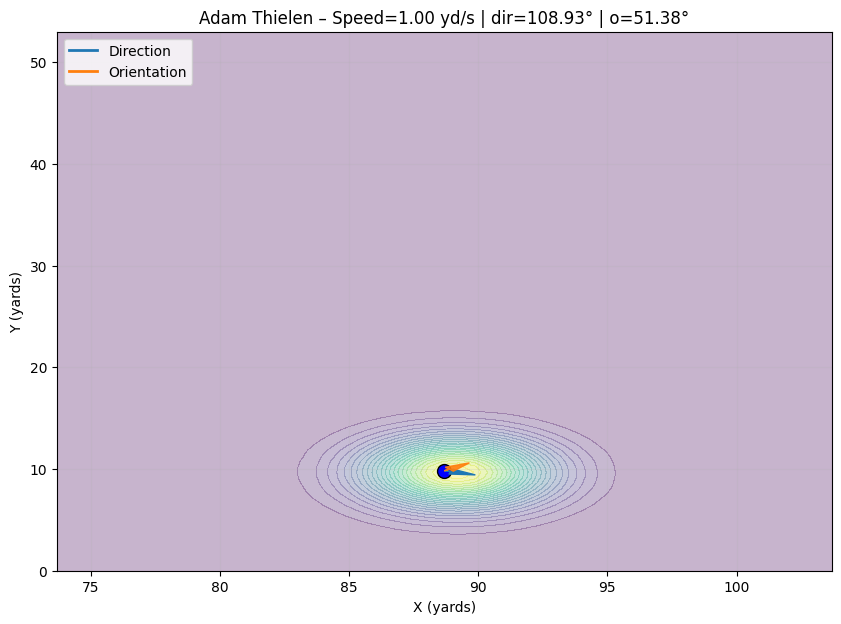

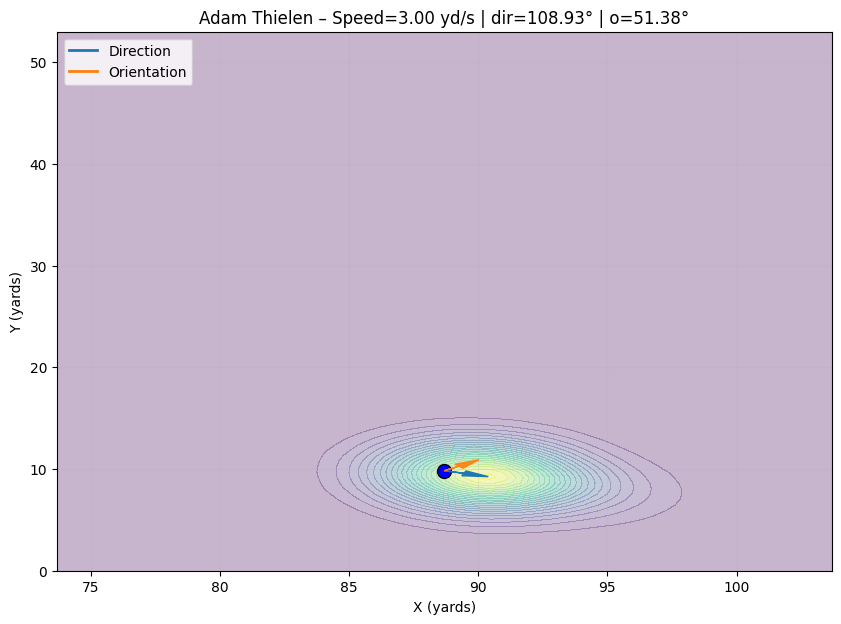

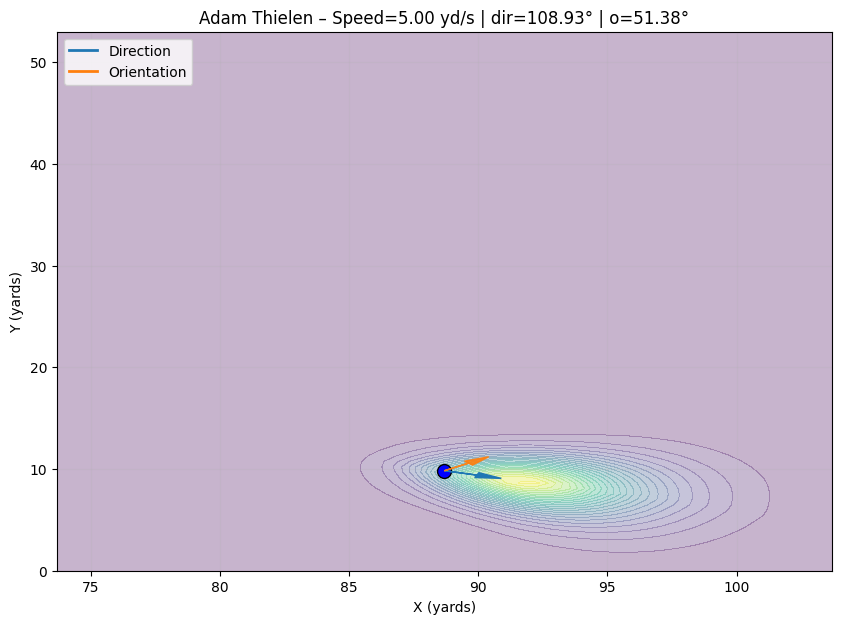

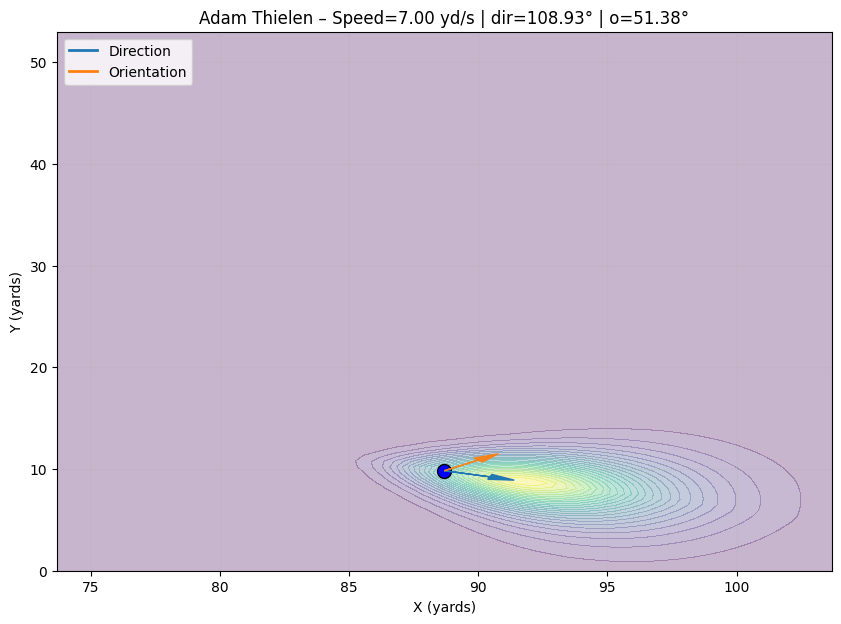

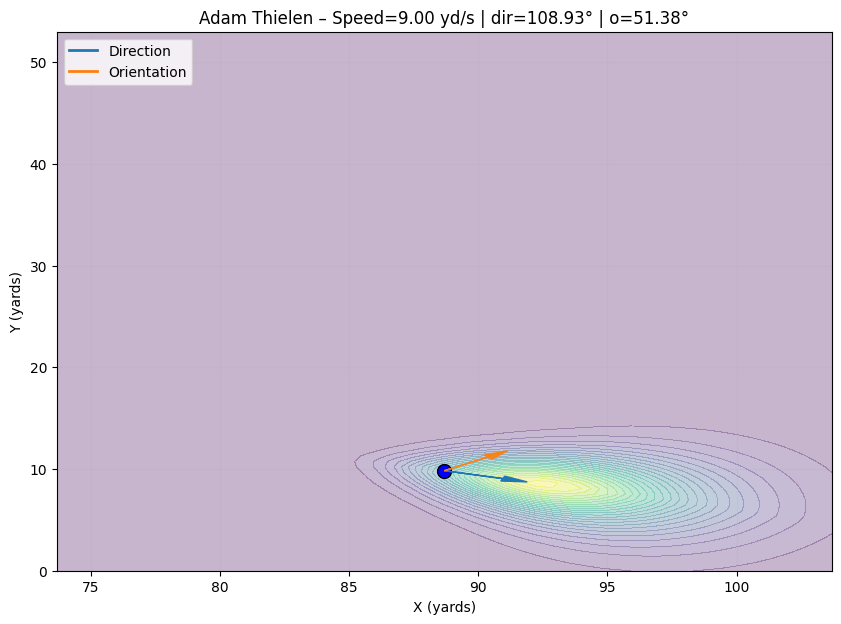

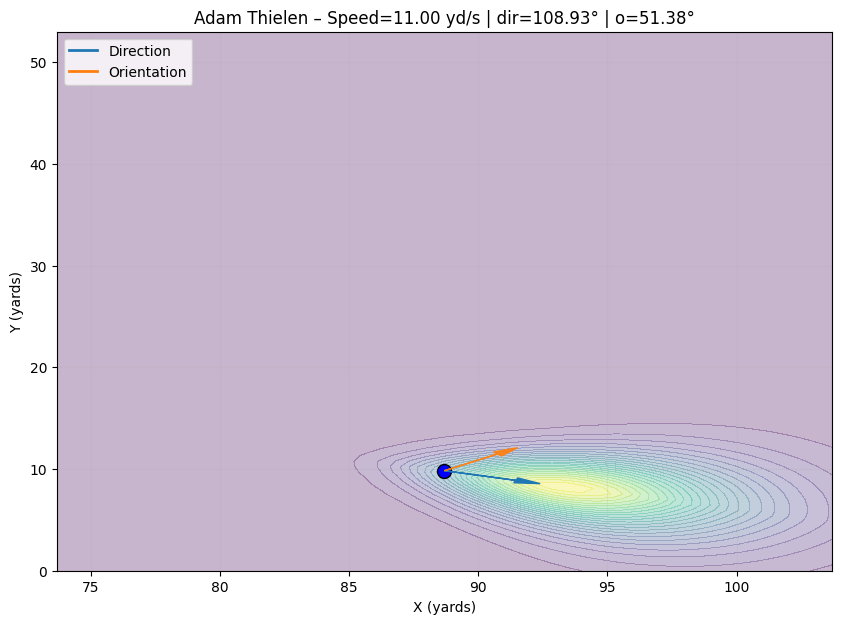

In [107]:
diagnostic_plot(
    df,
    frame_id=150,
    player_ids=one_player,
    speeds=(1, 3, 5, 7, 9, 11),
    orientation_bias_deg=90,
    sigma_gaussian=5,
    gaussian_scale_factor=0.8,
    alpha_gamma=9,
    max_forward_distance=25,
    forward_decay_factor=2.0,
    angle_limit_min=10,
    angle_limit_max=20,
    contour_levels=30,
    cmap='viridis',
    arrow_scale=3.0,
    arrow_head_width=0.5,
    arrow_head_length=1.0,
    zoom_x_range=15
)

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, Sequence, Tuple, List

def plot_field_control_small_multiples(
    df: pd.DataFrame,
    *,
    # columns
    frame_col: str = "frameId",
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",      # 0° = north/up, clockwise
    ori_col: str = "o",        # same convention as dir
    speed_col: str = "s",      # yards/s
    dist_from_ball_col: str = "dist_from_football",

    # model/grid
    grid_x_res: int = 200,
    grid_y_res: int = 100,
    field_x_max: float = 120.0,
    field_y_max: float = 53.3,
    orientation_bias_deg: float = 0.0,   # keep 0.0 unless you truly need a bias
    gaussian_scale_factor: float = 0.7,
    alpha_gamma: float = 11.0,
    beta_min: float = 1.0,
    beta_max: float = 20.0,
    gamma_midpoint: float = 15.0,
    gamma_scale_factor: float = 0.8,
    max_forward_distance: float = 25.0,
    forward_decay_factor: float = 1.0,
    angle_limit_min: float = 3.0,
    angle_limit_max: float = 67.0,
    angle_decay_factor: float = 2.0,
    w_gaussian_min: float = 0.2,
    w_gaussian_max: float = 1.0,
    gaussian_midpoint: float = 4.0,
    gaussian_steepness: float = 2.0,

    # plot styling
    cols: int = 3,                      # 6 panels → 2 rows x 3 cols by default
    contour_levels: int = 18,
    cmap: str = "Reds",
    contour_alpha: float = 0.30,
    arrow_scale: float = 3.0,           # smaller arrows as requested
    arrow_head_width: float = 0.5,
    arrow_head_length: float = 1.0,
    dir_color: str = "tab:blue",
    ori_color: str = "tab:orange",
    grid_alpha: float = 0.15,
    title_prefix: str = "Field Control (Gaussian–Gamma) • small multiples",
    show: bool = True,
) -> Tuple[plt.Figure, np.ndarray, List[int]]:
    """
    Small-multiples of *field control* (influence distribution) for a single player's rows.

    - Chooses **6 frames evenly spaced** from min(df[frame_col]) to max(df[frame_col]).
    - Uses the **actual speed** from the DataFrame at each frame.
    - Overlays *two arrows*: Direction (dir) and Orientation (o).
    - Draws the player location marker and the mixed influence density (Gaussian+Gamma).

    Returns
    -------
    fig, axes, frames_used
        Matplotlib figure, flat array of axes, and the exact frame IDs plotted.
    """
    # --- validate & reduce to a single player's time series -----------------
    if df.empty:
        raise ValueError("Input DataFrame is empty.")

    # unique frames actually present
    frames_present = np.sort(df[frame_col].unique())
    if frames_present.size < 1:
        raise ValueError(f"No '{frame_col}' values found.")

    # pick 6 evenly spaced targets and snap each to the nearest present frame
    target = np.linspace(frames_present.min(), frames_present.max(), 6)
    frames_used: List[int] = []
    for t in target:
        nearest = int(frames_present[np.argmin(np.abs(frames_present - t))])
        if len(frames_used) == 0 or frames_used[-1] != nearest:
            frames_used.append(nearest)
    # ensure we have exactly up to 6 unique frames
    frames_used = frames_used[:6]

    # --- build the model ----------------------------------------------------
    try:
        PlayerInfluenceModel  # type: ignore[name-defined]
    except NameError as e:
        raise NameError("PlayerInfluenceModel must be defined/imported before calling this function.") from e

    model = PlayerInfluenceModel(
        grid_x_res=grid_x_res, grid_y_res=grid_y_res,
        field_x_max=field_x_max, field_y_max=field_y_max,
        orientation_bias_deg=orientation_bias_deg,
        gaussian_scale_factor=gaussian_scale_factor,
        alpha_gamma=alpha_gamma,
        beta_min=beta_min, beta_max=beta_max,
        gamma_midpoint=gamma_midpoint, gamma_scale_factor=gamma_scale_factor,
        max_forward_distance=max_forward_distance, forward_decay_factor=forward_decay_factor,
        angle_limit_min=angle_limit_min, angle_limit_max=angle_limit_max, angle_decay_factor=angle_decay_factor,
        w_gaussian_min=w_gaussian_min, w_gaussian_max=w_gaussian_max,
        gaussian_midpoint=gaussian_midpoint, gaussian_steepness=gaussian_steepness,
    )
    X, Y = model.grid.X, model.grid.Y

    # --- layout -------------------------------------------------------------
    n = len(frames_used)
    rows = int(np.ceil(n / cols))
    aspect = field_y_max / field_x_max
    fig, axes = plt.subplots(rows, cols, figsize=(4.8 * cols, 4.8 * rows * aspect))
    axes = np.array(axes).reshape(-1)

    # --- per panel ----------------------------------------------------------
    for ax, fid in zip(axes, frames_used):
        row = df.loc[df[frame_col] == fid]
        if row.empty:
            ax.axis("off")
            continue
        r = row.iloc[0]

        x0, y0 = float(r[x_col]), float(r[y_col])
        dir_deg = float(r[dir_col]) if pd.notna(r[dir_col]) else None
        ori_deg = float(r[ori_col]) if (ori_col in r and pd.notna(r[ori_col])) else None
        spd = float(r[speed_col]) if (speed_col in r and pd.notna(r[speed_col])) else 0.0
        dball = float(r[dist_from_ball_col]) if (dist_from_ball_col in r and pd.notna(r[dist_from_ball_col])) else 0.0

        # density using ACTUAL speed
        if dir_deg is None:
            ax.axis("off"); continue
        pos = (x0, y0)
        pos_off = model.compute_offset(pos, dir_deg, spd)
        Z = model.base_distribution(
            pos_xy=pos, pos_off_xy=pos_off,
            direction_deg=dir_deg, speed=spd,
            dist_from_ball=dball
        )

        # draw field window
        ax.set_xlim(x0 - 20, x0 + 20)
        ax.set_ylim(0, field_y_max)
        for x in range(10, int(field_x_max), 10):
            ax.axvline(x, color="k", lw=1, alpha=0.06)

        # filled contours
        ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=contour_alpha)

        # player point
        ax.scatter(x0, y0, s=60, c="k", zorder=5)

        # arrows (same converter as class)
        L = (spd / 11.3) * arrow_scale
        th_dir = model.theta_from_tracking(dir_deg, apply_bias=False)
        ax.arrow(x0, y0, L*np.cos(th_dir), L*np.sin(th_dir),
                 head_width=arrow_head_width, head_length=arrow_head_length,
                 fc=dir_color, ec=dir_color, lw=1.5, zorder=6)

        if ori_deg is not None:
            th_ori = model.theta_from_tracking(ori_deg, apply_bias=False)
            ax.arrow(x0, y0, (L*0.9)*np.cos(th_ori), (L*0.9)*np.sin(th_ori),
                     head_width=arrow_head_width, head_length=arrow_head_length,
                     fc=ori_color, ec=ori_color, lw=1.5, alpha=0.9, zorder=6)

        t_dir = f"{dir_deg:.2f}°" if dir_deg is not None else "NA"
        t_ori = f"{ori_deg:.2f}°" if ori_deg is not None else "NA"
        ax.set_title(f"Frame {fid}  |  dir={t_dir}  |  o={t_ori}  |  s={spd:.2f} yd/s", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(alpha=grid_alpha)

    # turn off any extra axes
    for ax in axes[n:]:
        ax.axis("off")

    fig.suptitle(title_prefix, fontsize=14)
    fig.tight_layout(rect=[0, 0.02, 1, 0.95])

    if show:
        plt.show()
    return fig, axes, frames_used

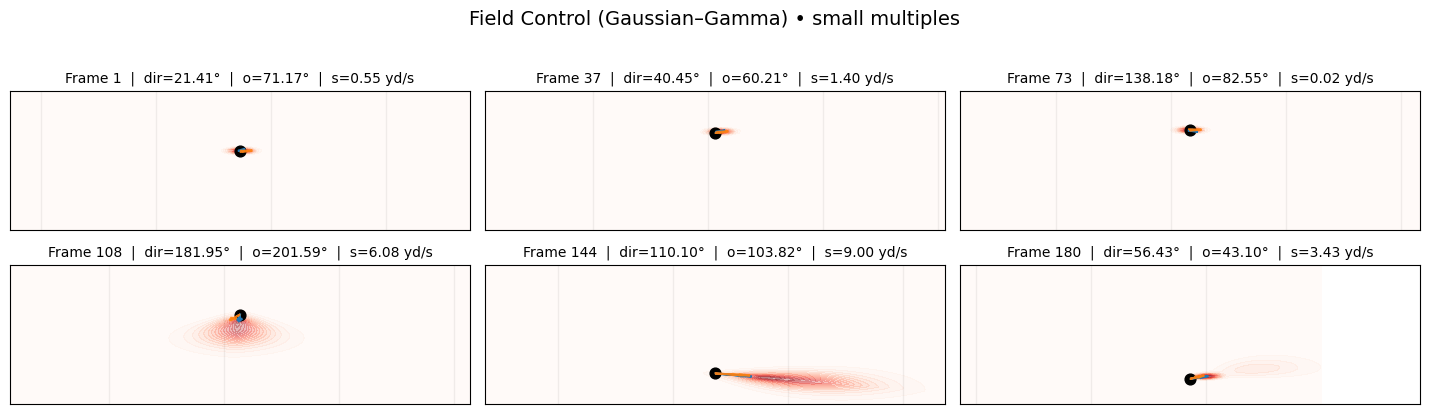

Frames plotted: [1, 37, 73, 108, 144, 180]


In [117]:
# df should be one player's rows with columns: frameId, x, y, dir, o, s, dist_from_football
fig, axes, frames = plot_field_control_small_multiples(single_player)
print("Frames plotted:", frames)  # e.g., [1, 30, 60, 90, 120, 150]


In [105]:
from __future__ import annotations

import math
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def diagnostic_multiples(
    df: pd.DataFrame,
    frame_id: int,
    player_id: Union[int, Sequence[int]],
    *,
    speed: float = 5.0,                 # Player evaluation speed (yd/s)

    # -------- Baseline knobs (applied to every panel unless overridden) ------
    # With the new class, keep this at 0.0 unless you *intentionally* want a bias.
    orientation_bias_deg: float = 0.0,
    gaussian_scale_factor: float = 0.7,
    alpha_gamma: float = 11.0,
    beta_min: float = 1.0,
    beta_max: float = 20.0,
    gamma_midpoint: float = 15.0,
    gamma_scale_factor: float = 0.8,
    max_forward_distance: float = 20.0,
    forward_decay_factor: float = 1.0,
    angle_limit_min: float = 15.0,
    angle_limit_max: float = 45.0,
    angle_decay_factor: float = 2.0,
    w_gaussian_min: float = 0.2,
    w_gaussian_max: float = 1.0,
    gaussian_midpoint: float = 4.0,
    gaussian_steepness: float = 2.0,

    # -------- Plot styling ---------------------------------------------------
    cmap: str = "Reds",
    alpha: float = 0.30,
    contour_levels: int = 18,
    zoom_x_range: float = 12.0,
    ylim: Optional[Tuple[float, float]] = (0.0, 53.0),
    grid_alpha: float = 0.20,
    cols: int = 4,

    # -------- Behavior / DF schema ------------------------------------------
    verbose: bool = False,
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",               # 0° up (+Y), 90° right (+X), clockwise increasing
    speed_col: str = "s",               # (not used; we evaluate at `speed`)
    dist_from_ball_col: str = "dist_from_football",
    name_col: str = "displayName",
) -> Tuple[plt.Figure, List[Dict[str, Any]]]:
    """
    Build a compact “cheat sheet” of small contour panels to visualize how each
    hyperparameter affects the Gaussian–Gamma influence field for one player.

    Each panel keeps the same player pose (position/heading) but overrides exactly
    one model knob, so you can see qualitative differences side-by-side.
    """
    # ---- Validate availability of the model --------------------------------
    try:
        PlayerInfluenceModel  # type: ignore[name-defined]
    except NameError as e:
        raise NameError(
            "PlayerInfluenceModel must be defined/imported before calling diagnostic_multiples()."
        ) from e

    # ---- Select the focal player row ---------------------------------------
    player_ids = np.atleast_1d(player_id)

    frame_rows = df[df["frameId"] == frame_id].copy()
    if name_col in frame_rows.columns:
        frame_rows = frame_rows[frame_rows[name_col].str.lower() != "football"]
    if frame_rows.empty:
        raise ValueError(f"No player rows found for frame_id={frame_id}.")

    sel = frame_rows[frame_rows["nflId"].isin(player_ids)]
    if sel.empty:
        sel = frame_rows  # fallback for demos

    row = sel.iloc[0]
    pos = (float(row[x_col]), float(row[y_col]))
    dir_deg = float(row[dir_col])
    dist = float(row[dist_from_ball_col]) if dist_from_ball_col in row and pd.notna(row[dist_from_ball_col]) else 0.0

    # ---- Helper to build a model with overrides ----------------------------
    def _build_model(**override: Any) -> PlayerInfluenceModel:
        model = PlayerInfluenceModel(
            orientation_bias_deg=orientation_bias_deg,  # defaults to 0.0 now
            gaussian_scale_factor=gaussian_scale_factor,
            alpha_gamma=alpha_gamma,
            beta_min=beta_min, beta_max=beta_max,
            gamma_midpoint=gamma_midpoint, gamma_scale_factor=gamma_scale_factor,
            max_forward_distance=max_forward_distance, forward_decay_factor=forward_decay_factor,
            angle_limit_min=angle_limit_min, angle_limit_max=angle_limit_max, angle_decay_factor=angle_decay_factor,
            w_gaussian_min=w_gaussian_min, w_gaussian_max=w_gaussian_max,
            gaussian_midpoint=gaussian_midpoint, gaussian_steepness=gaussian_steepness,
        )
        # Apply per-panel overrides
        for k, v in override.items():
            if not hasattr(model, k):
                raise AttributeError(f"Unknown model parameter '{k}'")
            setattr(model, k, v)
        return model

    # ---- Panels: (title, overrides) ----------------------------------------
    panels: List[Tuple[str, Dict[str, Any]]] = [
        ("Gaussian scale ↓", {"gaussian_scale_factor": max(0.2, gaussian_scale_factor * 0.6)}),
        ("Gaussian scale ↑", {"gaussian_scale_factor": gaussian_scale_factor * 1.4}),

        ("Gamma α ↓ (flatter)", {"alpha_gamma": max(2.0, alpha_gamma * 0.7)}),
        ("Gamma α ↑ (peakier)", {"alpha_gamma": alpha_gamma * 1.3}),

        ("Gamma reach ↓", {"max_forward_distance": max(6.0, max_forward_distance * 0.6)}),
        ("Gamma reach ↑", {"max_forward_distance": max_forward_distance * 1.4}),

        ("Gamma fade fast", {"forward_decay_factor": 0.6}),
        ("Gamma fade slow", {"forward_decay_factor": 2.0}),

        ("Cone narrow", {
            "angle_limit_min": min(max(angle_limit_min, 0.0) + 12.0, max(angle_limit_max - 5.0, angle_limit_min + 12.0)),
            "angle_limit_max": max(min(angle_limit_max, 85.0) - 12.0, angle_limit_min + 5.0),
        }),
        ("Cone wide", {
            "angle_limit_min": max(0.0, angle_limit_min - 12.0),
            "angle_limit_max": min(85.0, angle_limit_max + 12.0),
        }),

        ("More Gaussian", {"w_gaussian_min": min(0.8, w_gaussian_min + 0.2)}),
        ("More Gamma",    {"w_gaussian_min": max(0.0, w_gaussian_min - 0.2)}),
    ]

    # ---- Layout figure ------------------------------------------------------
    n = len(panels)
    cols_eff = max(1, int(cols))
    rows = math.ceil(n / cols_eff)
    fig, axes = plt.subplots(rows, cols_eff, figsize=(4.0 * cols_eff, 3.6 * rows))
    axes_arr = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

    panel_params: List[Dict[str, Any]] = []

    # ---- Render each panel --------------------------------------------------
    for ax, (title, overrides) in zip(axes_arr, panels):
        model = _build_model(**overrides)

        # Record the exact parameters used
        params = {
            "orientation_bias_deg": model.orientation_bias_deg,
            "gaussian_scale_factor": model.gaussian_scale_factor,
            "alpha_gamma": model.alpha_gamma,
            "beta_min": model.beta_min,
            "beta_max": model.beta_max,
            "gamma_midpoint": model.gamma_midpoint,
            "gamma_scale_factor": model.gamma_scale_factor,
            "max_forward_distance": model.max_forward_distance,
            "forward_decay_factor": model.forward_decay_factor,
            "angle_limit_min": model.angle_limit_min,
            "angle_limit_max": model.angle_limit_max,
            "angle_decay_factor": model.angle_decay_factor,
            "w_gaussian_min": model.w_gaussian_min,
            "w_gaussian_max": model.w_gaussian_max,
            "gaussian_midpoint": model.gaussian_midpoint,
            "gaussian_steepness": model.gaussian_steepness,
            "speed": speed,
        }
        panel_params.append({"title": title, "params": params})
        if verbose:
            print(f"[{title}] {params}")

        # Compute density for this panel / same player pose
        pos_off = model.compute_offset(pos, dir_deg, speed)
        Z = model.base_distribution(
            pos_xy=pos,
            pos_off_xy=pos_off,
            direction_deg=dir_deg,
            speed=speed,
            dist_from_ball=dist,
            alpha_gamma=model.alpha_gamma,
        )

        # Draw
        X, Y = model.grid.X, model.grid.Y
        ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)
        ax.scatter(pos[0], pos[1], c="blue", edgecolor="black", s=45, zorder=5)

        # Arrow with the NEW mapping
        theta = model.theta_from_tracking(dir_deg, apply_bias=False)
        L = (speed / 11.3) * 4.0  # a touch smaller for readability
        ax.arrow(
            pos[0], pos[1],
            L * np.cos(theta), L * np.sin(theta),
            head_width=0.8, head_length=1.6,
            fc="black", ec="black", zorder=6
        )

        ax.set_title(title, fontsize=10)
        ax.set_xlim(pos[0] - zoom_x_range, pos[0] + zoom_x_range)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.grid(alpha=grid_alpha)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any leftover empty axes
    for i in range(len(panels), len(axes_arr)):
        axes_arr[i].axis("off")

    fig.suptitle(
        f"Influence Cheat Sheet • frame {frame_id} • player {player_id} • speed={speed:.2f} yd/s",
        fontsize=14
    )
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])

    return fig, panel_params


In [123]:
print(params)

[{'title': 'Gaussian scale ↓', 'params': {'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.42, 'alpha_gamma': 11.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 5}}, {'title': 'Gaussian scale ↑', 'params': {'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.9799999999999999, 'alpha_gamma': 11.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 5}}, {'title': 'Gamma α ↓ (flatter)', 'params': {'orientation_bias_deg': 0.0

Best params: {'orientation_bias_deg': 0.0, 'gaussian_scale_factor': 0.7, 'alpha_gamma': 11.0, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 2.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 9}


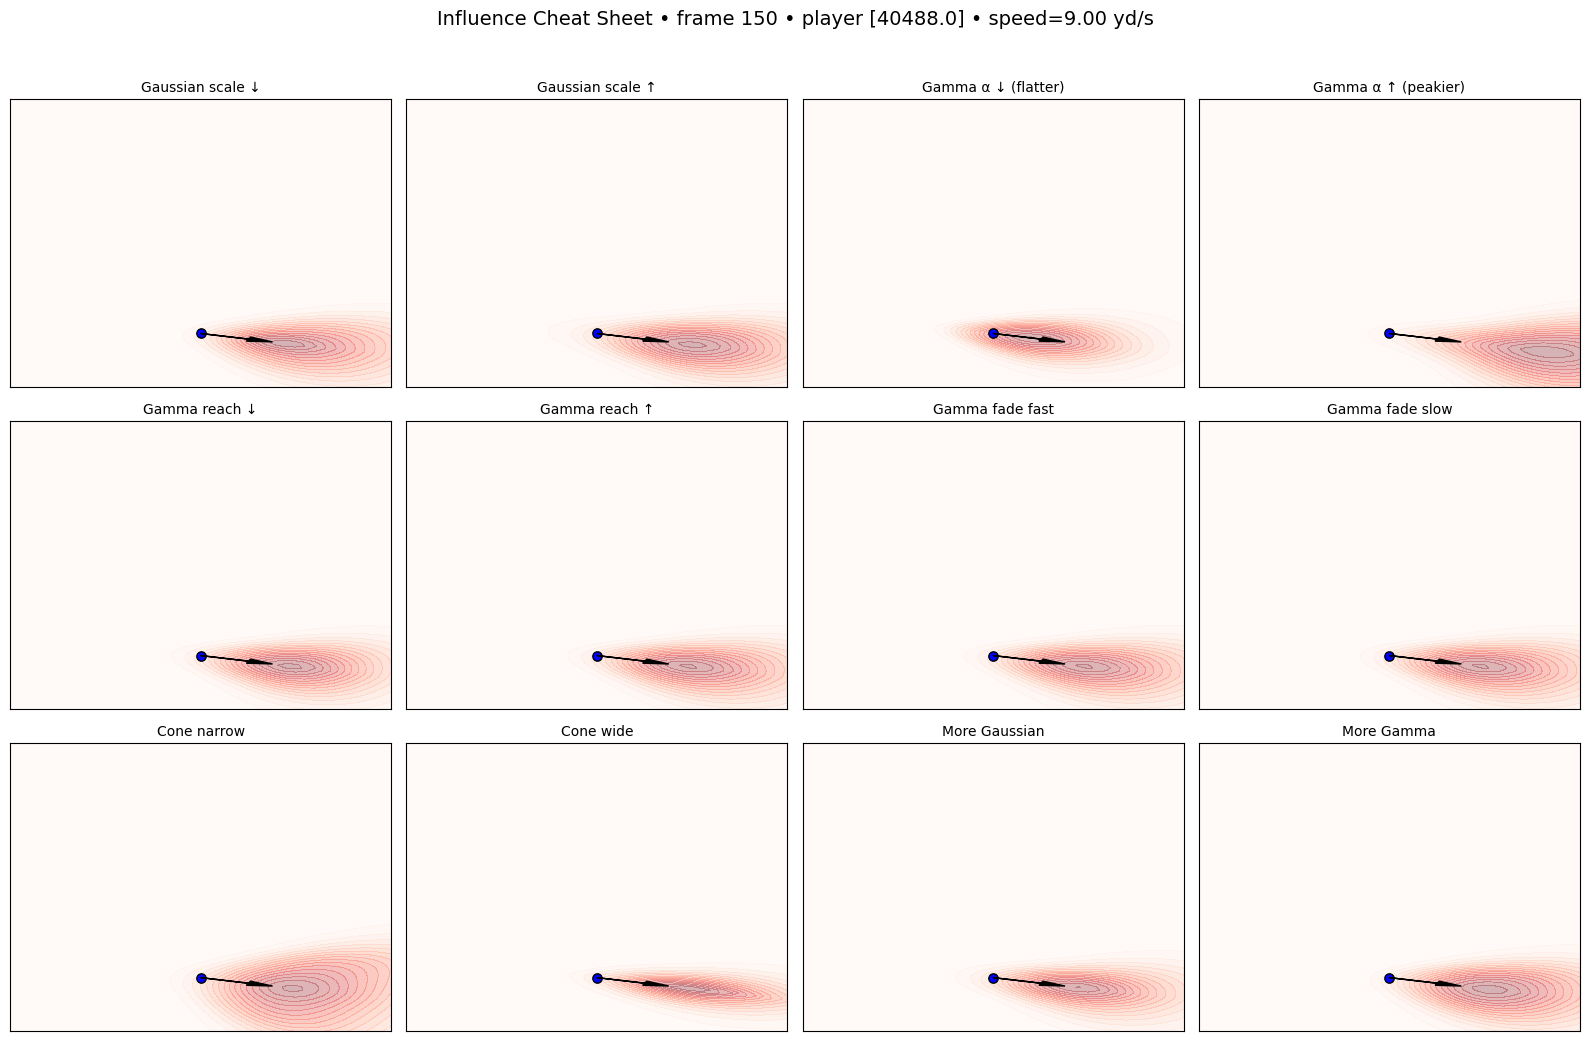

In [124]:
fig, params = diagnostic_multiples(df, frame_id=150, player_id=one_player, speed=9)

# Print the “winner” panel’s settings cleanly
best = next(p for p in params if p["title"] == "Gamma fade slow")  # for example
print("Best params:", best["params"])


In [118]:
def compute_player_densities_dataframe(
    df: pd.DataFrame,
    min_frame: int,
    max_frame: int,
    *,
    model_kwargs: Optional[dict] = None,   # e.g. {"orientation_bias_deg": 0.0, ...}
    alpha_gamma: float = 11.0,
    exclude_football: bool = True,
):
    """
    Compute Gaussian–Gamma densities for all players across [min_frame, max_frame]
    using PlayerInfluenceModel. Stores the orientation bias used so plotting
    can automatically match it later.

    Returns:
      - all_player_df: one row per (frameId, nflId) with the 2D 'density' grid
      - (X, Y): the model's grid (numpy arrays), for backward compatibility
    """
    if min_frame > max_frame:
        raise ValueError("min_frame must be less than or equal to max_frame.")

    # Build the model once with your chosen knobs
    model = PlayerInfluenceModel(**(model_kwargs or {}))
    X, Y = model.grid.X, model.grid.Y

    # Slice frames
    df_range = df[(df["frameId"] >= min_frame) & (df["frameId"] <= max_frame)].copy()
    if exclude_football and "displayName" in df_range.columns:
        df_range = df_range[df_range["displayName"].str.lower() != "football"]

    rows_out = []
    for frame_id in sorted(df_range["frameId"].unique()):
        frame_df = df_range[df_range["frameId"] == frame_id]
        if frame_df.empty:
            continue

        for _, r in frame_df.iterrows():
            try:
                pos = (float(r["x"]), float(r["y"]))
                dir_deg = float(r["dir"])
                spd = float(r["s"])
                dball = float(r.get("dist_from_football", 0.0))

                pos_off = model.compute_offset(pos, dir_deg, spd)
                Z = model.base_distribution(
                    pos_xy=pos,
                    pos_off_xy=pos_off,
                    direction_deg=dir_deg,
                    speed=spd,
                    dist_from_ball=dball,
                    alpha_gamma=alpha_gamma,
                )

                rows_out.append({
                    "frameId": frame_id,
                    "nflId": r["nflId"],
                    "displayName": r.get("displayName", None),
                    "jerseyNumber": r.get("jerseyNumber", None),
                    "x": pos[0],
                    "y": pos[1],
                    "speed": spd,
                    "direction": dir_deg,                    # raw tracking dir (0°=north, CW)
                    "is_off": r.get("is_off", None),
                    "dist_from_football": dball,
                    "orientation_bias_deg": model.orientation_bias_deg,  # store bias actually used
                    "density": Z,
                })
            except Exception as e:
                print(f"Error processing nflId={r.get('nflId')} in frame {frame_id}: {e}")

    all_player_df = pd.DataFrame(rows_out)
    return all_player_df, (X, Y)


In [119]:
def plot_player_densities_from_dataframe(
    player_df: pd.DataFrame,
    grid,                      # either (X, Y) tuple OR model.grid (Grid)
    frame_id: int,
    *,
    orientation_bias_deg: float = 0.0,   # fallback if a row doesn't store a bias
    contour_levels: int = 20,
    contour_alpha: float = 0.30,
    off_cmap: str = "Reds",
    on_cmap: str = "Blues",
    arrow_scale: float = 2.0,
    arrow_head_width: float = 0.375,
    arrow_head_length: float = 0.75,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    grid_alpha: float = 0.10,
    title: str = "Individual Player Influence",
    show: bool = True,
):
    """
    Plot precomputed densities. Arrows use the SAME angle mapping as the model:
        theta = radians(90 - direction_deg + row_bias)

    If a row lacks 'orientation_bias_deg', the function uses the fallback
    `orientation_bias_deg` provided here.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Accept either (X, Y) or a Grid object
    try:
        # Grid-like object with X, Y attributes
        X, Y = grid.X, grid.Y
    except AttributeError:
        # Tuple or list
        X, Y = grid

    _MAX_FIELD_X, _MAX_FIELD_Y = 120.0, 53.3

    f = player_df[player_df["frameId"] == frame_id].copy()
    if f.empty:
        print(f"Warning: no players found for frameId={frame_id}")
        return

    aspect = _MAX_FIELD_Y / _MAX_FIELD_X
    fig, ax = plt.subplots(figsize=(20, 20 * aspect))

    # Light yard lines
    for x in range(10, int(_MAX_FIELD_X), 10):
        ax.axvline(x, color="k", linestyle="-", alpha=0.05)

    def theta_from_tracking(deg: float, bias_deg: float) -> float:
        # Your convention → matplotlib radians (0 rad = +X, CCW)
        return np.deg2rad((90.0 - deg + bias_deg) % 360.0)

    for _, row in f.iterrows():
        if str(row.get("displayName", "")).lower() == "football":
            continue

        is_off = row.get("is_off", None)
        player_color = "blue" if is_off == 1 else "red"
        density_cmap = on_cmap if is_off == 1 else off_cmap

        # use per-row stored bias if present, otherwise the provided fallback
        row_bias = float(row.get("orientation_bias_deg", orientation_bias_deg))

        Z = row["density"]
        Z_masked = np.where(Z > 0.01, Z, np.nan)
        ax.contourf(X, Y, Z_masked, cmap=density_cmap, levels=contour_levels, alpha=contour_alpha)

        x0, y0 = float(row["x"]), float(row["y"])
        ax.scatter(x0, y0, color=player_color, s=200, edgecolor="black", zorder=5)

        jn = row.get("jerseyNumber", None)
        if jn is not None and not (isinstance(jn, float) and np.isnan(jn)):
            ax.text(x0, y0, f"{int(jn)}", fontsize=8, ha="center", color="white", zorder=6)

        name = row.get("displayName", None)
        if name:
            ax.text(x0, y0 - 1.5, str(name), fontsize=8, ha="center", color="black", zorder=6)

        dir_deg = row.get("direction", row.get("orientation", None))
        if dir_deg is not None:
            th = theta_from_tracking(float(dir_deg), row_bias)
            spd = float(row.get("speed", 0.0))
            L = arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)  # modest speed scaling
            ax.arrow(
                x0, y0,
                L * np.cos(th), L * np.sin(th),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc="black", ec="black", zorder=4
            )

    ax.set_title(f"{title} — Frame {frame_id}")
    ax.set_xlabel("X (yards)")
    ax.set_ylabel("Y (yards)")
    ax.grid(alpha=grid_alpha)

    ax.set_xlim(*xlim) if xlim else ax.set_xlim(0, _MAX_FIELD_X)
    ax.set_ylim(*ylim) if ylim else ax.set_ylim(0, _MAX_FIELD_Y)

    if show:
        plt.show()

    return fig, ax


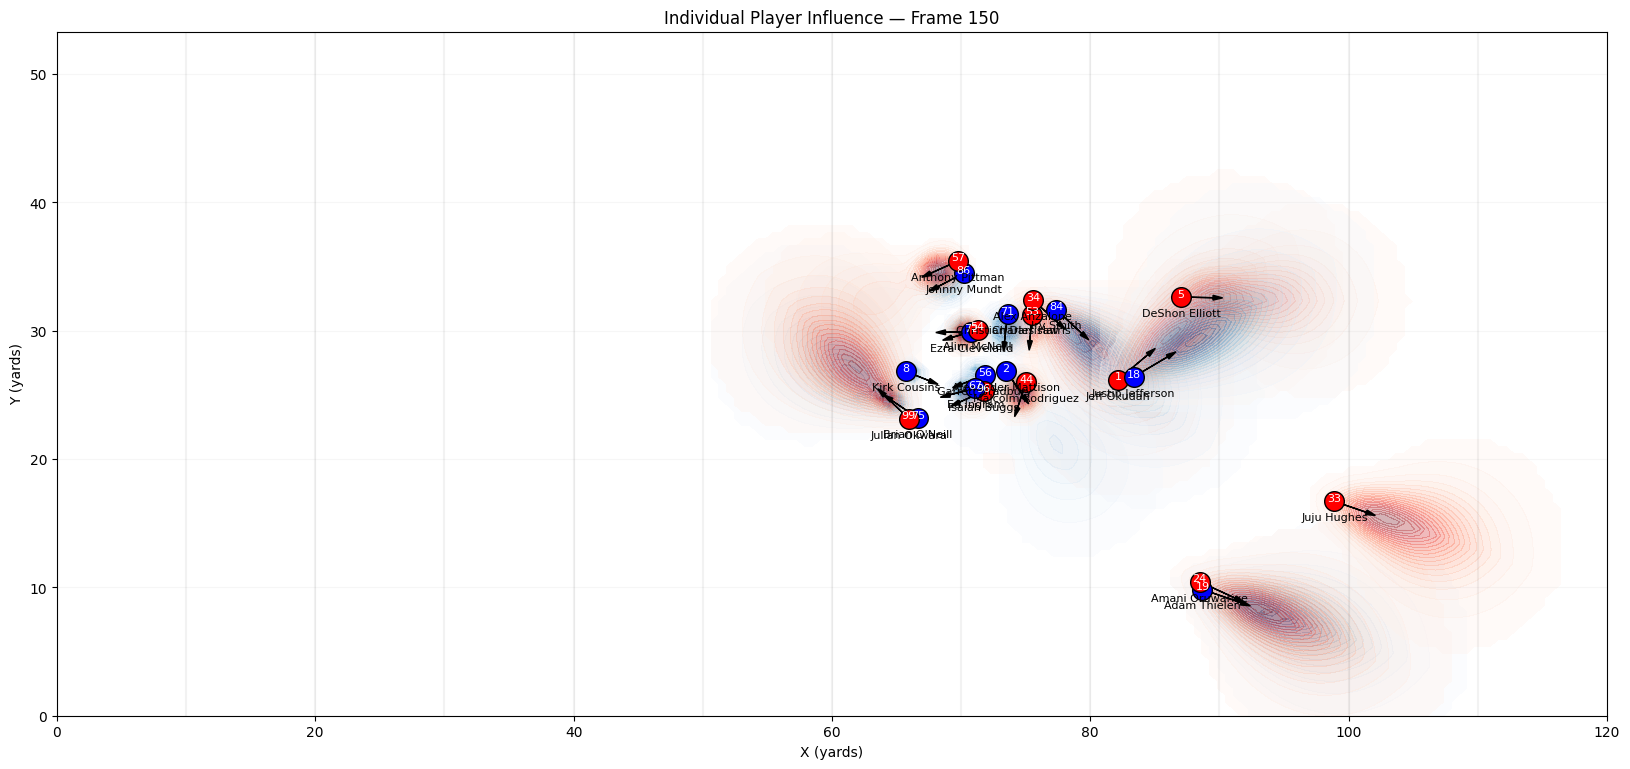

(<Figure size 2000x888.333 with 1 Axes>,
 <Axes: title={'center': 'Individual Player Influence — Frame 150'}, xlabel='X (yards)', ylabel='Y (yards)'>)

In [127]:
# 1) Compute densities (bias saved into each row)
all_player_df, grid = compute_player_densities_dataframe(
    df,
    min_frame=100,
    max_frame=150,
    model_kwargs={
        "orientation_bias_deg": 0.0,   # set a bias ONLY if you truly want it
        "gaussian_scale_factor": 0.5,
        "alpha_gamma": 5,
        "max_forward_distance": 20.0,
        "forward_decay_factor": 1.2,
        "angle_limit_min": 3,
        "angle_limit_max": 57,
        "angle_decay_factor": 2.0,
        "w_gaussian_min": 0.2,
        "w_gaussian_max": 1.0,
        "gaussian_midpoint": 4.0,
        "gaussian_steepness": 2.0,
    },
    alpha_gamma=11,
)

# 2) Plot a single frame, arrows aligned to the SAME bias used at compute time
plot_player_densities_from_dataframe(
    all_player_df,
    grid,
    frame_id=150,
    orientation_bias_deg=0.0,   # only used if a row is missing its stored bias
    title="Individual Player Influence",
    arrow_scale=1.8,            # tweak arrow size if you like
)


In [133]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
from matplotlib import animation
from typing import Optional, Tuple


class AnimatePlayWithDensity:
    def __init__(
        self,
        play_df: pd.DataFrame,
        precomputed_df: pd.DataFrame,
        grid,                              # (X, Y) tuple OR a Grid object with .X/.Y
        plot_size_len: float = 16.0,
        *,
        # contours
        show_contours: bool = True,
        contour_levels: int = 20,
        contour_alpha: float = 0.30,
        off_cmap: str = "Reds",
        on_cmap: str  = "Blues",
        # arrows
        arrow_scale: float = 2.0,          # base arrow length (yards), modestly scaled by speed
        arrow_head_width: float = 0.375,
        arrow_head_length: float = 0.75,
        # orientation fallback (used ONLY if a row lacks stored bias)
        orientation_bias_deg: float = 0.0, # new default: no extra bias unless you want it
        # view
        xlim: Optional[Tuple[float, float]] = None,
        ylim: Optional[Tuple[float, float]] = None,
        grid_alpha: float = 0.10,
        title: str = "Play Animation with Influence",
    ) -> None:
        """
        Animate a play using *precomputed* per-player densities.

        Inputs
        ------
        play_df : tracking-like rows for a single play (all frames)
        precomputed_df : rows from `compute_player_densities_dataframe` with:
            - frameId, nflId, x, y, speed, is_off, density
            - orientation_bias_deg (stored at compute time)  ← preferred for arrows
            - OPTIONAL: theta_rad (already-resolved heading used by the model)
        grid : either (X, Y) from the model OR `model.grid` (Grid with .X/.Y)

        Notes
        -----
        - Angles follow your tracking convention: 0° = north (+Y), clockwise.
        - We convert to Matplotlib radians with: θ = radians(90 - deg + bias).
        - Bias is taken per-row from `precomputed_df.orientation_bias_deg` when present,
          otherwise falls back to the constructor's `orientation_bias_deg`.
        """

        # constants
        self._MAX_FIELD_Y = 53.3
        self._MAX_FIELD_X = 120.0
        self._MAX_FIELD_PLAYERS = 22  # pre-allocate text/arrow artists

        # data
        self._frame_data = play_df.copy()
        self._precomputed_df = precomputed_df.copy()

        # grid: accept either Grid object or (X, Y)
        try:
            self._X, self._Y = grid.X, grid.Y
        except AttributeError:
            self._X, self._Y = grid

        self._frames = sorted(self._frame_data.frameId.unique())

        # style / options
        self.show_contours = show_contours
        self.contour_levels = contour_levels
        self.contour_alpha = contour_alpha
        self.off_cmap = off_cmap
        self.on_cmap = on_cmap

        self.arrow_scale = arrow_scale
        self.arrow_head_width = arrow_head_width
        self.arrow_head_length = arrow_head_length

        self.orientation_bias_deg = float(orientation_bias_deg)  # fallback only
        self.xlim = xlim
        self.ylim = ylim
        self.grid_alpha = grid_alpha
        self._title = title

        # stream
        self._stream = self.data_stream()

        # fig/axes
        aspect = self._MAX_FIELD_Y / self._MAX_FIELD_X
        self._fig = plt.figure(figsize=(plot_size_len, plot_size_len * aspect))
        self._ax_field = plt.gca()

        # storage for artists
        self._scat_jersey_list = []
        self._scat_number_list = []
        self._scat_name_list = []
        self._a_dir_list = []
        self._a_or_list = []
        self._contours = []

        # start animation
        self.ani = animation.FuncAnimation(
            self._fig, self.update, frames=len(self._frames),
            init_func=self.setup_plot, blit=False
        )
        plt.close()

    # ---------- angle helper (single source of truth) ----------
    @staticmethod
    def _theta_from_tracking(deg: float, bias_deg: float) -> float:
        """Convert tracking degrees (0°=north, clockwise) → matplotlib radians."""
        return np.deg2rad((90.0 - float(deg) + float(bias_deg)) % 360.0)

    # ---------- plumbing ----------
    @staticmethod
    def set_axis_plots(ax, max_x, max_y) -> None:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xlim([0, max_x])
        ax.set_ylim([0, max_y])

    def data_stream(self):
        for frame in self._frames:
            yield self._frame_data[self._frame_data.frameId == frame]

    def setup_plot(self):
        # Field setup
        self.set_axis_plots(self._ax_field, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        for idx in range(10, int(self._MAX_FIELD_X), 10):
            self._ax_field.axvline(idx, color='k', linestyle='-', alpha=0.05)

        # Initial scatters
        self._scat_ball = self._ax_field.scatter([], [], s=100, color='black', label="Football")
        self._scat_offense = self._ax_field.scatter([], [], s=500, color='blue', edgecolors='k', label="Offense")
        self._scat_defense = self._ax_field.scatter([], [], s=500, color='red', edgecolors='k', label="Defense")

        # Pre-allocate text + arrows (so we can update in-place)
        for _ in range(self._MAX_FIELD_PLAYERS):
            self._scat_jersey_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='white'))
            self._scat_number_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._scat_name_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._a_dir_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='k')))
            self._a_or_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='grey', width=2)))

        # Title & view
        self._ax_field.set_title(self._title)
        if self.xlim: self._ax_field.set_xlim(*self.xlim)
        if self.ylim: self._ax_field.set_ylim(*self.ylim)
        self._ax_field.grid(alpha=self.grid_alpha)

        return (self._scat_ball, self._scat_offense, self._scat_defense, *self._scat_jersey_list)

    def clear_contours_safe(self, contours_list):
        """Safely clear matplotlib contours across different versions."""
        for contour in contours_list:
            try:
                if hasattr(contour, 'collections'):
                    for collection in contour.collections:
                        collection.remove()
                elif hasattr(contour, 'remove'):
                    contour.remove()
                else:
                    for artist in contour:
                        if hasattr(artist, 'remove'):
                            artist.remove()
            except (TypeError, AttributeError, ValueError):
                continue
        contours_list.clear()

    def update(self, _frame_index):
        # grab next frame of positional data
        try:
            pos_df = next(self._stream)
        except StopIteration:
            # Reset the stream when it's exhausted
            self._stream = self.data_stream()
            pos_df = next(self._stream) # get the first frame of the reset stream

        frame_id = int(pos_df.frameId.iloc[0])

        # split
        offense_df = pos_df[pos_df.is_off == 1]
        defense_df = pos_df[pos_df.is_off == 0]
        ball_df    = pos_df[pos_df.team == 'football'] if 'team' in pos_df.columns \
                     else pos_df[pos_df.displayName.str.lower() == 'football']

        # update scatters
        if not offense_df.empty:
            self._scat_offense.set_offsets(np.vstack([offense_df.x, offense_df.y]).T)
        if not defense_df.empty:
            self._scat_defense.set_offsets(np.vstack([defense_df.x, defense_df.y]).T)
        if not ball_df.empty:
            self._scat_ball.set_offsets(np.vstack([ball_df.x, ball_df.y]).T)

        self._ax_field.set_title(f"{self._title} — Frame {frame_id}")

        # clear old contours
        self.clear_contours_safe(self._contours)

        # plot densities for this frame
        if self.show_contours:
            frame_density_df = self._precomputed_df[self._precomputed_df.frameId == frame_id]
            for _, prow in frame_density_df.iterrows():
                Z = prow.get('density', None)
                if Z is None:
                    continue
                cmap = self.on_cmap if prow.get('is_off', 0) == 1 else self.off_cmap
                Z_masked = np.where(Z > 0.01, Z, np.nan)
                cont = self._ax_field.contourf(self._X, self._Y, Z_masked,
                                               cmap=cmap, levels=self.contour_levels, alpha=self.contour_alpha)
                self._contours.append(cont)

        # update per-player labels + arrows
        labeled = pos_df[pos_df.jerseyNumber.notnull()].reset_index(drop=True)
        for idx in range(min(len(labeled), self._MAX_FIELD_PLAYERS)):
            row = labeled.iloc[idx]
            x0, y0 = float(row.x), float(row.y)

            # jersey/number/name
            self._scat_jersey_list[idx].set_position((x0, y0))
            self._scat_jersey_list[idx].set_text(row.position if 'position' in row else '')
            self._scat_number_list[idx].set_position((x0, y0 + 1.5))
            try:
                self._scat_number_list[idx].set_text(int(row.jerseyNumber))
            except Exception:
                self._scat_number_list[idx].set_text('')
            self._scat_name_list[idx].set_position((x0, y0 - 1.5))
            name = row.displayName.split()[-1] if isinstance(row.displayName, str) else ''
            self._scat_name_list[idx].set_text(name)

            # Resolve heading (direction) for this player
            theta_rad = None
            # Prefer precomputed theta_rad if stored for this player+frame
            match = self._precomputed_df[
                (self._precomputed_df.frameId == frame_id) & (self._precomputed_df.nflId == row.nflId)
            ]
            if not match.empty:
                theta_rad = match.iloc[0].get('theta_rad', None)

            # If not stored, compute from raw `dir` + the bias that was used at compute time (if present)
            if theta_rad is None:
                row_bias = self.orientation_bias_deg
                if not match.empty and ('orientation_bias_deg' in match.columns):
                    try:
                        row_bias = float(match.iloc[0].get('orientation_bias_deg', row_bias))
                    except Exception:
                        pass
                theta_rad = self._theta_from_tracking(float(row.dir), row_bias)

            # direction arrow length (modest speed scaling)
            spd = float(row.s) if 's' in row else 0.0
            L = self.arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)

            # "direction" (black) arrow
            self._a_dir_list[idx].remove()
            self._a_dir_list[idx] = self._ax_field.add_patch(
                Arrow(x0, y0, L*np.cos(theta_rad), L*np.sin(theta_rad),
                      color='k', width=0.0, alpha=1.0)
            )

            # "orientation" (grey) arrow — optional (uses row.o if present)
            self._a_or_list[idx].remove()
            orient_theta = None
            if ('o' in row) and (row.o == row.o):  # pd.notna(row.o) without importing pd here
                # Use the same bias logic as direction
                orient_theta = self._theta_from_tracking(float(row.o), row_bias)
                self._a_or_list[idx] = self._ax_field.add_patch(
                    Arrow(x0, y0, (L*0.6)*np.cos(orient_theta), (L*0.6)*np.sin(orient_theta),
                          color='grey', width=2, alpha=0.9)
                )
            else:
                self._a_or_list[idx] = self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='grey', width=0))


        # Hide any unused artists
        for idx in range(len(labeled), self._MAX_FIELD_PLAYERS):
             self._scat_jersey_list[idx].set_text('')
             self._scat_number_list[idx].set_text('')
             self._scat_name_list[idx].set_text('')
             self._a_dir_list[idx].remove()
             self._a_or_list[idx].remove()


        return (self._scat_ball, self._scat_offense, self._scat_defense, *self._scat_jersey_list, *self._scat_number_list, *self._scat_name_list, *self._a_dir_list, *self._a_or_list)

In [135]:
# 1) Compute per-player densities for a frame range
all_player_df, grid = compute_player_densities_dataframe(
    df=df,                # full tracking data for the play
    min_frame=1,
    max_frame=max(df['frameId']),
    model_kwargs={
        "orientation_bias_deg": 0.0,   # ← bias applied at density compute time
        "gaussian_scale_factor": 0.7,
        "alpha_gamma": 7,
        "max_forward_distance": 20.0,
        "forward_decay_factor": 1.2,
        "angle_limit_min": 3,
        "angle_limit_max": 57,
        "angle_decay_factor": 2.0,
        "w_gaussian_min": 0.2,
        "w_gaussian_max": 1.0,
        "gaussian_midpoint": 4.0,
        "gaussian_steepness": 2.0,
    },
    alpha_gamma=11,
)

# 2) Animate the play with precomputed densities
animator = AnimatePlayWithDensity(
    play_df=df,         # your play’s positional data (all frames)
    precomputed_df=all_player_df,
    grid=grid,
    plot_size_len=16,
    orientation_bias_deg=0.0,    # fallback if per-row bias is missing
    arrow_scale=1.4,             # smaller arrows
    title="Pitch Control + Player Influence"
)

# 3) Display the animation inline (in Colab / Jupyter)
from IPython.display import HTML
HTML(animator.ani.to_jshtml())

# OR save to a file:
animator.ani.save("play_influence.mp4", fps=10, dpi=150)


This is where we look at offense versus defense teams pitch control

In [136]:

def compute_player_densities_with_pitch_control(
    model,
    df,
    frame_id,
    *,
    grid=None,                          # (X, Y) tuple or Grid; if None, uses model.grid or default
    smooth_sigma=2.0,                   # gaussian smoothing for influence maps
    pitch_k=25.0,                       # sigmoid steepness for pitch control
    neutral_band=(0.45, 0.55),          # mask band for "neutral" areas
    use_cached_density=True,            # use 'density' column if available
    cache_back_to_df=False,             # if computed, store density back onto df for reuse
    # ---- column names (match your tracking schema) ----
    name_col: str = "displayName",
    id_col: str = "nflId",
    team_side_col: str = "is_off",
    x_col: str = "x",
    y_col: str = "y",
    dir_col: str = "dir",               # your tracking: 0° = north, clockwise
    speed_col: str = "s",               # yards / second
    dist_from_ball_col: str = "dist_from_football",
    cache_col: str = "density",         # where cached density lives (if present)
):
    """
    Compute offense/defense influence and pitch control for a single frame with your
    updated PlayerInfluenceModel.

    Inputs
    ------
    model : PlayerInfluenceModel
        Must expose `compute_offset(pos, dir_deg, speed)` and
        `base_distribution(pos, pos_off, dir_deg, speed, dist_from_ball, alpha_gamma=...)`.
        Should also expose `model.grid` (Grid with .X/.Y).
    df : pandas.DataFrame
        Tracking-like data. Rows for the requested frame must include positions,
        direction (deg, 0°=north CW), speed, team side, etc.
    frame_id : int
        Frame to compute.

    Keyword options
    ---------------
    grid : (X, Y) tuple or a Grid, optional
        If None, uses `model.grid`; otherwise falls back to a 120x53.3 default grid.
    smooth_sigma : float
        Sigma for gaussian smoothing (applied to the team-summed maps).
    pitch_k : float
        Steepness of sigmoid mapping (defense - offense) -> [0,1] pitch control.
    neutral_band : (lo, hi)
        Inclusive band of near-50/50 control to mask (set to NaN).
    use_cached_density : bool
        If True and an existing per-row `cache_col` is present and non-null, use it.
    cache_back_to_df : bool
        If True and densities are computed now, write them back into `cache_col`.
    *column names*
        Override if your DF uses different names.

    Returns
    -------
    player_df : pd.DataFrame
        Per-player rows for the frame with a 'density' array and 'sum_density'.
    offense_influence_df : pd.DataFrame  (index=y, columns=x)
        Smoothed team-summed offensive influence.
    defense_influence_df : pd.DataFrame  (index=y, columns=x)
        Smoothed team-summed defensive influence.
    pitch_control_df : pd.DataFrame      (index=y, columns=x)
        Pitch control (masked in neutral band). Higher values → defense control.
    """
    import numpy as np
    import pandas as pd
    from scipy.ndimage import gaussian_filter

    # --- grid setup ----------------------------------------------------------
    if grid is not None:
        try:
            X, Y = grid.X, grid.Y   # Grid object
        except AttributeError:
            X, Y = grid              # (X, Y) tuple
    elif hasattr(model, "grid") and getattr(model, "grid") is not None:
        # Your class stores a Grid object with .X and .Y
        X, Y = model.grid.X, model.grid.Y
    else:
        x_vals = np.linspace(0.0, 120.0, 200)
        y_vals = np.linspace(0.0, 53.3, 100)
        X, Y = np.meshgrid(x_vals, y_vals)

    x_vals = X[0, :]
    y_vals = Y[:, 0]

    # --- helpers -------------------------------------------------------------
    def _sigmoid(z, k):
        return 1.0 / (1.0 + np.exp(-k * z))

    def _safe_norm(A):
        mx = A.max()
        return A / mx if mx > 0 else A

    # --- frame slice ---------------------------------------------------------
    frame_df = df.loc[df["frameId"] == frame_id].copy()
    if frame_df.empty:
        raise ValueError(f"No data found for frame {frame_id}.")

    # Exclude the ball and rows without side info
    if name_col in frame_df.columns:
        frame_df = frame_df[frame_df[name_col].str.lower() != "football"]
    frame_df = frame_df[frame_df[team_side_col].notna()].copy()

    if frame_df.empty:
        raise ValueError(f"No player rows (excluding football) with '{team_side_col}' for frame {frame_id}.")

    # --- density acquisition -------------------------------------------------
    # Decide whether we can use cached densities
    can_use_cache = (
        use_cached_density
        and (cache_col in frame_df.columns)
        and frame_df[cache_col].notna().all()
    )

    if can_use_cache:
        # stack into (n_players, ny, nx)
        densities = np.stack(frame_df[cache_col].to_numpy(), axis=0)

    else:
        # Compute per-row using the class recipe
        dens_list = []
        for _, r in frame_df.iterrows():
            pos = (float(r[x_col]), float(r[y_col]))
            dir_deg = float(r[dir_col])
            spd = float(r[speed_col]) if speed_col in frame_df.columns else 0.0
            dball = float(r.get(dist_from_ball_col, 0.0))

            pos_off = model.compute_offset(pos, dir_deg, spd)
            Z = model.base_distribution(
                pos_xy=pos,
                pos_off_xy=pos_off,
                direction_deg=dir_deg,
                speed=spd,
                dist_from_ball=dball,
            )
            dens_list.append(Z)

        densities = np.stack(dens_list, axis=0)
        if cache_back_to_df:
            frame_df.loc[:, cache_col] = dens_list

    # --- clean tiny speckle --------------------------------------------------
    densities = np.where(densities < 1e-3, 0.0, densities)

    # --- split & accumulate offense/defense ---------------------------------
    is_off_mask = frame_df[team_side_col].to_numpy().astype(bool)
    inf_offense = densities[is_off_mask].sum(axis=0) if is_off_mask.any() else np.zeros_like(X)
    inf_defense = densities[~is_off_mask].sum(axis=0) if (~is_off_mask).any() else np.zeros_like(X)

    # normalize to [0,1] (guards against extreme scales), then smooth
    inf_offense = _safe_norm(inf_offense)
    inf_defense = _safe_norm(inf_defense)

    if smooth_sigma and smooth_sigma > 0:
        inf_offense = gaussian_filter(inf_offense, sigma=smooth_sigma)
        inf_defense = gaussian_filter(inf_defense, sigma=smooth_sigma)

    # --- pitch control -------------------------------------------------------
    # convention here: higher -> defense control; invert if you want offense
    pitch_control = _sigmoid(inf_defense - inf_offense, k=pitch_k)

    lo, hi = neutral_band
    mask = (pitch_control >= lo) & (pitch_control <= hi)
    pitch_control_masked = np.where(mask, np.nan, pitch_control)

    # --- per-player summary table -------------------------------------------
    sum_density = densities.reshape(densities.shape[0], -1).sum(axis=1)
    player_df = frame_df.assign(
        frameId=frame_id,
        sum_density=sum_density,
    ).copy()

    # provide friendly synonyms if your upstream plots expect them
    if "direction" not in player_df.columns and dir_col in player_df.columns:
        player_df["direction"] = player_df[dir_col]
    if "speed" not in player_df.columns and speed_col in player_df.columns:
        player_df["speed"] = player_df[speed_col]
    if cache_col not in player_df.columns:
        player_df[cache_col] = list(densities)

    # --- grid → DataFrames (y as index, x as columns) -----------------------
    offense_influence_df = pd.DataFrame(inf_offense, index=y_vals, columns=x_vals)
    defense_influence_df = pd.DataFrame(inf_defense, index=y_vals, columns=x_vals)
    pitch_control_df     = pd.DataFrame(pitch_control_masked, index=y_vals, columns=x_vals)

    return player_df, offense_influence_df, defense_influence_df, pitch_control_df


In [63]:
def visualize_pitch_control_with_players(pitch_control_df, player_df, frame_id):
    """
    Visualize the pitch control grid for a single frame with player positions, jersey numbers,
    player names, and directional arrows based on speed and orientation.
    """
    def corrected_orientation(original_orientation):
        """Correct orientation: 0° is North, 90° is East."""
        return (90 - original_orientation) % 360

    plt.figure(figsize=(12, 6))
    plt.title(f"Team Field Control - At Snap")

    # Plot pitch control
    plt.contourf(pitch_control_df.columns, pitch_control_df.index, pitch_control_df,
                 cmap='coolwarm', levels=20, alpha=0.8)
    plt.colorbar(label="Field Control")

    # Plot player positions and details
    for _, row in player_df[player_df['frameId'] == frame_id].iterrows():
        color = 'blue' if row.is_off else 'red'  # Offensive (red) or defensive (blue)
        player_pos = (row.x, row.y)

        # Plot player position
        plt.scatter(player_pos[0], player_pos[1], color=color, edgecolor='black', s=100, zorder=5)

        # Add player jersey number and name
        if pd.notna(row['jerseyNumber']):
            plt.text(player_pos[0], player_pos[1] + 1, f"{int(row['jerseyNumber'])}",
                     fontsize=10, ha='center', color='black', zorder=6)
        if pd.notna(row['displayName']):
            plt.text(player_pos[0], player_pos[1] - 1.5, row['displayName'],
                     fontsize=8, ha='center', color='black', zorder=6)

        # Add directional arrow based on orientation and speed
        if pd.notna(row['direction']) and pd.notna(row['speed']):
            theta = np.radians(corrected_orientation(row['direction']))
            arrow_length = row['speed'] / 11.3 * 5  # Normalize arrow length
            plt.arrow(player_pos[0], player_pos[1],
                      arrow_length * np.cos(theta),
                      arrow_length * np.sin(theta),
                      head_width=.375, head_length=.75, fc='black', ec='black', zorder=2)
    plt.xlim(60,110)
    plt.ylim(5,45)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(alpha=0.5)
    plt.show()


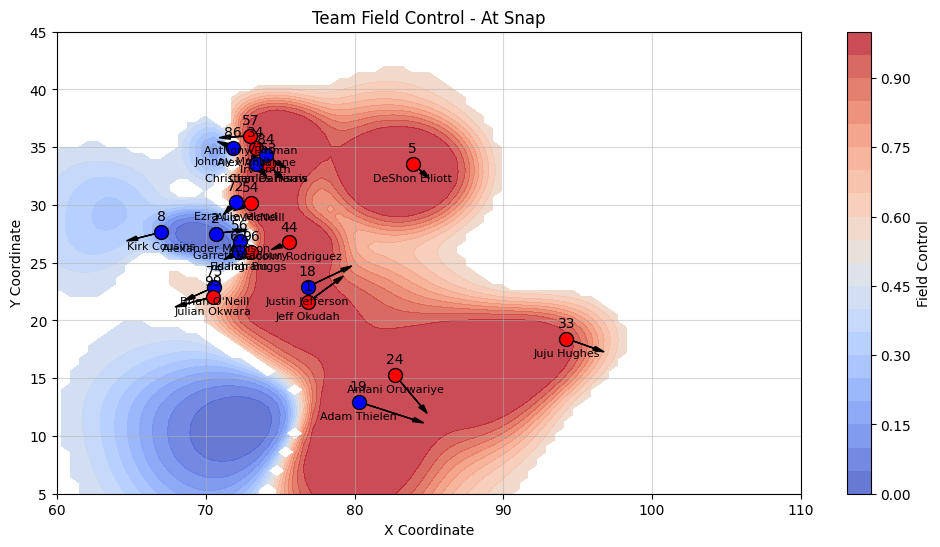

In [72]:
# 1) Make sure densities are numpy arrays and consistent shape
player_df["density"] = player_df["density"].apply(lambda d: np.asarray(d, dtype=float))
ny, nx = player_df["density"].iloc[0].shape  # e.g., (100, 200)

# 2) Build a grid that matches those shapes
x_vals = np.linspace(0.0, 120.0, nx)
y_vals = np.linspace(0.0, 53.3, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# 3) Compute pitch control using cached densities (no model)
player_df2, offense_df, defense_df, pitch_control_df = compute_player_densities_with_pitch_control(
    model=None,
    df=player_df,
    frame_id=140,
    grid=(X, Y),
    use_cached_density=True,
    cache_back_to_df=False
)

# 4) Visualize
visualize_pitch_control_with_players(pitch_control_df, player_df2, frame_id=140)
